In [ ]:
# !pip install imblearn

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
# building spark session
spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.driver.memory", "30g") \
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.local.dir", "/tmp/spark-temp") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.3") \
    .config("spark.sql.shuffle.partitions", "400") \
    .getOrCreate()
spark

In [3]:
# cleaned data loading
data = spark.read.parquet("dataset_no_missing_values")
data = data.repartition(64)

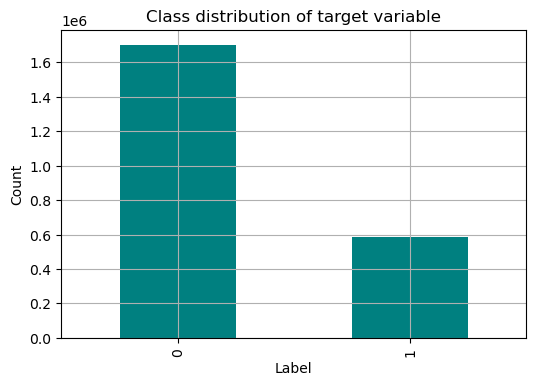

Percentage distribution of the target:
 Label
0    74.448915
1    25.551085
Name: proportion, dtype: float64


In [4]:
# checking the balance of the label
y = data.select('Label').toPandas()
y = y['Label']

plt.figure(figsize=(6,4))
y.value_counts().plot(kind='bar', color= 'teal')
plt.title('Class distribution of target variable')
plt.xlabel('Label')
plt.ylabel('Count')
plt.grid(True)
plt.show()

class_distribution = y.value_counts(normalize=True) * 100
print("Percentage distribution of the target:\n", class_distribution)

**SMOTE**

In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd

train_data, val_data = data.randomSplit([0.8, 0.2], seed=42)
train_pd = train_data.toPandas()

X_train = train_pd.drop(columns=['Label'])
y_train = train_pd['Label']

print(f"We're using' a sample of {X_train.shape[0]} records for SMOTE")

We're using' a sample of 1830199 records for SMOTE


In [6]:
# applying SMOTE with different k_neighbors and sampling strategies to choose the best parameters

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import f1_score, precision_score, recall_score
import pandas as pd

results = []

k_values = [3, 5, 7]
sampling_strategies = ['auto', 0.5, 0.75, 1.0]

for k in k_values:
    for strategy in sampling_strategies:
        try:
            # SMOTE
            smote = SMOTE(k_neighbors=k, sampling_strategy=strategy, random_state=42)
            X_res, y_res = smote.fit_resample(X_train, y_train)

            df_res = pd.DataFrame(X_res, columns=X_train.columns)
            df_res['Label'] = y_res
            df_spark = spark.createDataFrame(df_res)

            # logistic regression model
            assembler = VectorAssembler(inputCols=X_train.columns.tolist(), outputCol="features")
            lr = LogisticRegression(featuresCol="features", labelCol="Label")
            pipeline = Pipeline(stages=[assembler, lr])
            model = pipeline.fit(df_spark)

            # predictions
            predictions = model.transform(val_data)

            # evaluation metrics
            evaluator_acc = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="accuracy")
            accuracy = evaluator_acc.evaluate(predictions)
            
            evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName='fMeasureByLabel', metricLabel=1, beta=1.0)
            f1 = evaluator_f1.evaluate(predictions)
            
            evaluator_roc = BinaryClassificationEvaluator(labelCol="Label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
            roc_auc = evaluator_roc.evaluate(predictions)

            # df_preds = predictions.select("Label", "prediction").toPandas()
            # f1 = f1_score(df_preds["Label"], df_preds["prediction"])
            # precision = precision_score(df_preds["Label"], df_preds["prediction"])
            # recall = recall_score(df_preds["Label"], df_preds["prediction"])

            results.append({
                'k_neighbors': k,
                'sampling_strategy': strategy,
                'accuracy': accuracy,
                'roc_auc': roc_auc,
                'f1_score': f1
                # 'precision': precision,
                # 'recall': recall
            })

            print(f"SMOTE(k={k}, strategy={strategy}): acc={accuracy:.4f}, roc_auc={roc_auc:.4f}, f1={f1:.4f}")
        
        except Exception as e:
            print(f"Błąd dla k={k}, strategy={strategy}: {e}")

SMOTE(k=3, strategy=auto): acc=0.6609, roc_auc=0.6993, f1=0.4845
SMOTE(k=3, strategy=0.5): acc=0.7474, roc_auc=0.6997, f1=0.3778
SMOTE(k=3, strategy=0.75): acc=0.7121, roc_auc=0.6995, f1=0.4619
SMOTE(k=3, strategy=1.0): acc=0.6609, roc_auc=0.6993, f1=0.4845
SMOTE(k=5, strategy=auto): acc=0.6615, roc_auc=0.6992, f1=0.4844
SMOTE(k=5, strategy=0.5): acc=0.7474, roc_auc=0.6997, f1=0.3780
SMOTE(k=5, strategy=0.75): acc=0.7122, roc_auc=0.6994, f1=0.4620
SMOTE(k=5, strategy=1.0): acc=0.6615, roc_auc=0.6992, f1=0.4844
SMOTE(k=7, strategy=auto): acc=0.6613, roc_auc=0.6992, f1=0.4843
SMOTE(k=7, strategy=0.5): acc=0.7474, roc_auc=0.6997, f1=0.3779
SMOTE(k=7, strategy=0.75): acc=0.7123, roc_auc=0.6994, f1=0.4622
SMOTE(k=7, strategy=1.0): acc=0.6613, roc_auc=0.6992, f1=0.4843


**Regularyzacja**

In [7]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, conv, when, trim
from pyspark.sql.types import IntegerType, LongType

feature_columns = [col for col in data.columns if col != 'Label']

# pipeline for logistic regression
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
lr = LogisticRegression(featuresCol="features", labelCol="Label", maxIter=100)
pipeline = Pipeline(stages=[assembler, lr])

# grid search for hyperparameters
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .build()

# evaluator

# evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="accuracy")
evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName='fMeasureByLabel', metricLabel=1, beta=1.0)

# cross-validation
cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3,           
                    parallelism=2,       
                    seed=42)

# training
cv_model = cv.fit(train_data)

# evaluating the best model
best_model = cv_model.bestModel
best_lr_model = best_model.stages[-1]  

print(f"Best elasticNetParam: {best_lr_model._java_obj.getElasticNetParam()}")
print(f"Best regParam: {best_lr_model._java_obj.getRegParam()}")

Best elasticNetParam: 0.0
Best regParam: 0.01


In [8]:
print(f"Model coefficients: {model.stages[1].coefficients}")
print(f"Model intercept: {model.stages[1].intercept}")

Model coefficients: [0.062140688942635934,0.0020547872355367925,0.021583126175576853,-1.698701323551772e-05,-0.002689162677298365,0.002980248145497424,0.06996725621840215,0.2041948939122073,-0.07758315623862189,-2.5022187122578865e-11,-2.056316037750919e-11,1.75411130479477e-11,-1.6483799536232757e-11,-6.282076431737122e-11,1.1913491934079018e-11,1.8842986834662598e-11,-6.185432634580977e-11,5.975877452684425e-10,-4.50111188696925e-12,-3.1080714623450447e-12,-2.259992462843265e-11,8.131168089374848e-12,-1.0401327081299466e-10,2.520917951632131e-11,1.486764167305051e-11,7.351310876836031e-11,1.237996096209354e-11,-3.7878429216598885e-11,1.9337446851364984e-10,6.130427369249875e-12,-1.429463645302418e-10,-9.423985333614851e-12,-3.0268487344101185e-11,-2.6293654408681073e-11]
Model intercept: -1.954758047569619
